In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('data/train.csv', nrows = 2000, index_col = 0)

n_days = 1099
days_in_week = 7
n_weeks = n_days // days_in_week
if (n_days % days_in_week != 0): n_weeks += 1

# For 1st consumer

## Without weights (algorithm 0.1)
Read data for 1 customer

In [21]:
f = open('data/train.csv')
f.readline()
line = f.readline()
ind, line = line.split(',')
ind = str(ind)
line = line.strip()
visites = [int(s) for s in line.split(' ')];


Make matrix of visits of customer

In [22]:


def make_visit_matrix(visites):
    V = np.zeros(shape = (n_weeks, 7), dtype = int)
    for day in visites:
        V[day // 7, day%7 - 1] = 1
    V = pd.DataFrame(V, columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    V.index = V.index + 1
    return V
    
V = make_visit_matrix(visites)


Drop empty weeks, leave last week for testing

In [23]:
for i in V.index:
    if (not np.any(V.loc[i,:])):
        V = V.drop(i)

V_test = V.iloc[0]
V = V.iloc[0:]
n_weeks -= 1
V_test

Mon    0
Tue    1
Wed    0
Thu    0
Fri    0
Sat    0
Sun    0
Name: 5, dtype: int64

In [28]:
# for ind in V.index:
#     flag = True
#     for i in V.columns:
#         if (V.loc[ind, i] == 1) and flag:
#             V.loc[ind] = 0
#             V.loc[ind, i] = w[ind - 1]
# V

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
5,0.000000,0.012569,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011899
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011396
20,0.000000,0.011312,0.000000,0.000000,0.000000,0.000000,0.000000
26,0.000000,0.000000,0.000000,0.010809,0.000000,0.000000,0.000000
35,0.000000,0.000000,0.000000,0.010055,0.000000,0.000000,0.000000
49,0.000000,0.000000,0.000000,0.000000,0.000000,0.008882,0.000000
61,0.000000,0.000000,0.000000,0.000000,0.000000,0.007877,0.000000
66,0.007458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007374


Count probabilities p_i - probability, that consumer will visit the shop in i-th day.
 (Для кожного дня і це ймовірності схеми Бернуллі - випробуванням є кожен тиждень, а успіх - якщо того тижня відвідувач приходив і-го дня. Сума не обов'язково рівна 1)

In [24]:
p = V.sum().to_numpy() / V.shape[0]

Count probabilities of first visit

In [7]:
p_ = np.zeros(7)
for i in range(7):
    p_[i] = (1 - p[:i]).prod() * p[i]

# check
print(p_.sum() + (1 - p).prod()) # = 1

1.0


Prediction

In [8]:
predicted_day = np.argmax(p_)
predicted_day;

## With weights (algorithm 1.0)

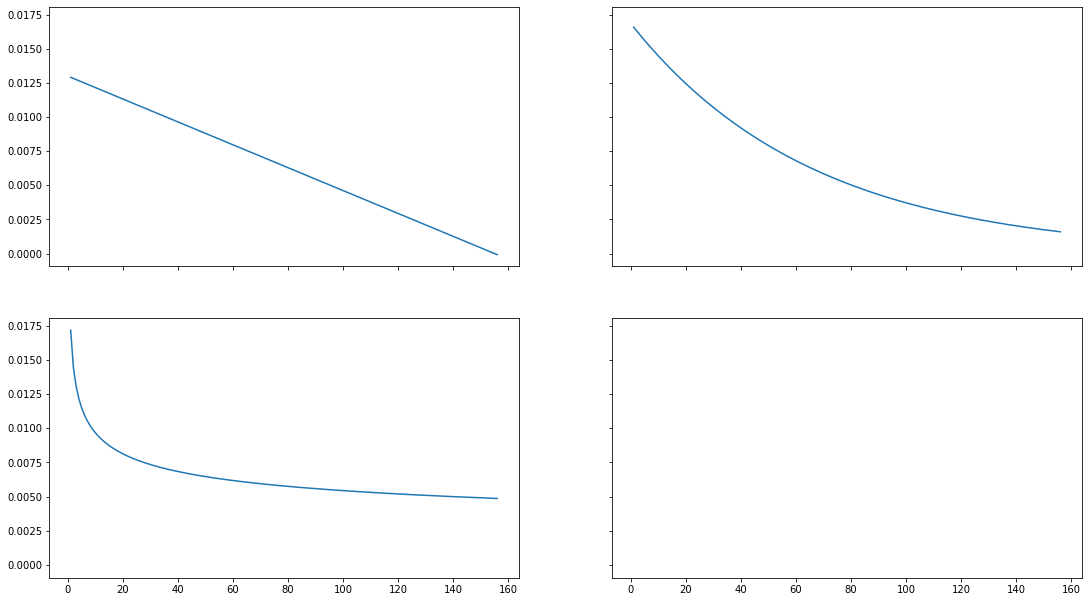

In [9]:
weeks = range(1, n_weeks+1)

w_lin = np.array([(n_weeks - i - 1)/n_weeks for i in weeks])
w_lin = w_lin / w_lin.sum()

lambd = 0.985
w_exp = np.array([lambd**(i) for i in weeks])
w_exp = w_exp / w_exp.sum()

gamma = 0.25
w_recip = np.array([1/i**(gamma) for i in weeks])
w_recip = w_recip / w_recip.sum()

#plotting of three profiles of weights
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5, forward=True)
ax[0, 0].plot(weeks, w_lin)
ax[0, 1].plot(weeks, w_exp)
ax[1, 0].plot(weeks, w_recip);

Count weighted probabilities p and p_

In [10]:
w = w_lin
for ind in V.index:
    V.loc[ind, :] *= w[ind]

    
p = V.sum(axis=0)
p_ = np.zeros(7)
for i in range(7):
    p_[i] = (1 - p[:i]).prod() * p[i]

# check
print(p_.sum() + (1 - p).prod()) # == 1
p_

1.0


array([0.00888219, 0.03878432, 0.0036708 , 0.03871281, 0.01189477,
       0.02302705, 0.03431483])

Predict

In [11]:
predicted_day = np.argmax(p_)
predicted_day;

## Evaluation

In [12]:
# from numpy.random import default_rng
# rng = default_rng(142)
# index_random = rng.permutation(V.index)
# test_proportion = 0.25
# n_test = int(np.floor(test_proportion * len(V.index)))
# V_test, V_train = V.loc[index_random[:n_test]], V.loc[index_random[n_test:]]



In [13]:
# test_proportion = 0.25
# n_test = int(np.floor(test_proportion * len(V.index)))

# V_test, V_train = V.iloc[-n_test:, :], V.iloc[:-n_test, :]

In [14]:
def is_true_prediction(V_test, predicted_day):
    return (V_test.iloc[predicted_day] == 1) and (V_test.iloc[:predicted_day].sum() == 0)


# For all consumers

In [15]:
# def parse_visites(ind):
df.loc[1][0]

' 30 84 126 135 137 179 242 342 426 456 460 462 483 594 600 604 704 723 744 787 804 886 924 928 946 954 1039 1040 1052'

In [16]:
def parse_visites(ind):
    line = df.loc[ind][0]
    line = line.strip()
    visites = [int(s) for s in line.split(' ')]
    return visites
    
visites = parse_visites(19);

In [18]:
n_weeks = n_days // days_in_week
if (n_days % days_in_week != 0): n_weeks += 1
print("weeks: ", n_weeks)

def make_visit_matrix(visites):        
    V = np.zeros(shape = (n_weeks, 7), dtype = int)
    for day in visites:
        V[(day-1) // 7, (day-1) % 7] = 1
    V = pd.DataFrame(V, columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    V.index = V.index + 1
    return V.iloc[:-1], V.iloc[-1]
    
    
V, V_test = make_visit_matrix(visites)
n_weeks -= 1
V.shape, V_test.shape
V.head()

weeks:  157


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0


In [19]:
def drop_empty_weeks(V):
    for i in V.index:
        if (not np.any(V.loc[i,:])):
            V = V.drop(i)
    return V

V = drop_empty_weeks(V)

In [ ]:
def get_weights(n_weeks, choose='lin'):
    weeks = range(1, n_weeks+1)
    if (choose == 'lin'):
        w_lin = np.array([(n_weeks - i - 1)/n_weeks for i in weeks])
        w_lin = w_lin / w_lin.sum()
        return w_lin
    elif (choose == 'exp'):
        lambd = 0.985
        w_exp = np.array([lambd**(i) for i in weeks])
        w_exp = w_exp / w_exp.sum()
        return w_exp
    elif (choose == 'recip'):
        gamma = 0.25
        w_recip = np.array([1/i**(gamma) for i in weeks])
        w_recip = w_recip / w_recip.sum()
        return w_recip
    
    
w = get_weights(n_weeks)

In [ ]:
def compute_p(w):
    for ind in V.index:
        V.loc[ind, :] *= w[ind]
    p = V.sum(axis=0)
    return p
    
p = compute_p(w)   
def compute_p_(p):
    p_ = np.zeros(7)
    for i in range(7):
        p_[i] = (1 - p[:i]).prod() * p[i]
    return p_

p_ = compute_p_(p)
# check
print(p_.sum() + (1 - p).prod()) # == 1
p_;

In [ ]:
def predict(p_):
    return np.argmax(p_)

predicted_day = predict(p_)

In [ ]:
def is_true_prediction(V_test, predicted_day):
    return (V_test.iloc[predicted_day] == 1) and (V_test.iloc[:predicted_day].sum() == 0)

